In [206]:
import sqlite3
import pandas as pd

# Connecting to the database
conn = sqlite3.connect('/Users/diboshbaruah/Desktop/Database.db')
data = pd.read_sql_query('SELECT * FROM Automobile_data', conn)

print("Dataset successfully loaded...\n")

# Displaying the first few rows to inspect the data
print("Displaying first few rows of the dataset:\n")
print(data.head())

# Checking data types before conversion
print("\nData types before conversion:")
print(data.dtypes)

# Closing the connection
conn.close()



Dataset successfully loaded...

Displaying first few rows of the dataset:

   r  m (kg)      Mt  Ewltp (g/km)        Ft Fm  ec (cm3)  ep (KW)  z (Wh/km)  \
0  1  1262.0  1352.0         133.0    petrol  M     999.0     84.0        NaN   
1  1  2434.0  2559.0           0.0  electric  E       NaN    300.0      193.0   
2  1  1984.0  2095.0           0.0  electric  E       NaN    220.0      157.0   
3  1  1314.0  1386.0         149.0    petrol  M    1498.0     78.0        NaN   
4  1  1075.0  1145.0         119.0       lpg  B    1242.0     51.0        NaN   

   Erwltp (g/km)  Fuel consumption   Electric range (km)  
0           1.56                5.8                  NaN  
1            NaN                NaN                445.0  
2            NaN                NaN                455.0  
3            NaN                6.6                  NaN  
4            NaN                6.0                  NaN  

Data types before conversion:
r                        int64
m (kg)                

In [208]:
#Checking for missing values in the dataset
print("\nChecking for missing values:")
print(data.isnull().sum())



Checking for missing values:
r                           0
m (kg)                     39
Mt                      48308
Ewltp (g/km)             1969
Ft                          0
Fm                          0
ec (cm3)               155677
ep (KW)                  3304
z (Wh/km)              780824
Erwltp (g/km)          462075
Fuel consumption       296752
Electric range (km)    783035
dtype: int64


In [212]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Stripping leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Handling Missing Values for Categorical Features
# Impute missing values for categorical features using the mode 
data['Ft'] = data['Ft'].fillna(data['Ft'].mode()[0])
data['Fm'] = data['Fm'].fillna(data['Fm'].mode()[0])

# Removing rows where the target variable 'Fuel consumption' is missing
data = data[data['Fuel consumption'].notnull()]

# Imputing Missing Values for Numerical Features
# Defining the list of numerical columns to impute
numerical_columns = ['m (kg)', 'Mt', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Erwltp (g/km)']

# Creating an imputer for numerical columns, using median strategy
imputer = SimpleImputer(strategy='median')

# Imputing missing values for numerical columns using .loc[] 
existing_numerical_columns = [col for col in numerical_columns if col in data.columns]
data.loc[:, existing_numerical_columns] = imputer.fit_transform(data[existing_numerical_columns])

# Droping columns with too many missing values 
columns_to_drop = ['z (Wh/km)', 'Erwltp (g/km)']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]
data = data.drop(columns=columns_to_drop)

# Imputing missing `Electric range (km)` based on fuel type
# Setting `Electric range (km)` to 0 for non-electric vehicles
data['Electric range (km)'] = data.apply(lambda row: 0 if row['Ft'] != 'electric' else row['Electric range (km)'], axis=1)

# Imputing missing values for electric vehicles
data['Electric range (km)'] = data['Electric range (km)'].fillna(data['Electric range (km)'].median())

# Checking if there are any missing values after imputation
print("\nMissing values after imputation:")
print(data.isnull().sum())



Missing values after imputation:
r                      0
m (kg)                 0
Mt                     0
Ewltp (g/km)           0
Ft                     0
Fm                     0
ec (cm3)               0
ep (KW)                0
Fuel consumption       0
Electric range (km)    0
dtype: int64


In [214]:
# Dropping features that may not be useful for the model (e.g., 'r' and 'Mt')
data = data.drop(columns=['r', 'Mt'])


In [216]:
# Performing one-hot encoding on categorical columns
data_encoded = pd.get_dummies(data, columns=['Ft', 'Fm'], drop_first=True)  # drop_first=True avoids multicollinearity

# Checking the columns after encoding
print(data_encoded.columns)


Index(['m (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'Fuel consumption',
       'Electric range (km)', 'Ft_PETROL', 'Ft_PETROL/ELECTRIC', 'Ft_diesel',
       'Ft_diesel/electric', 'Ft_e85', 'Ft_electric', 'Ft_hydrogen', 'Ft_lpg',
       'Ft_ng', 'Ft_petrol', 'Ft_petrol/electric', 'Fm_E', 'Fm_F', 'Fm_H',
       'Fm_M', 'Fm_P'],
      dtype='object')


In [218]:
# Splitting the dataset into training, evaluation, and production sets
train_data = data_encoded[:700000]
eval_data = data_encoded[700000:900000]
prod_data = data_encoded[900000:]

# Defining the features (X) and target (y)
X_train = train_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_train = train_data['Fuel consumption']

X_eval = eval_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_eval = eval_data['Fuel consumption']

X_prod = prod_data.drop(columns=['Fuel consumption', 'Electric range (km)'])
y_prod = prod_data['Fuel consumption']

# Printing the shapes of the splits
print("Training Data Shape:", train_data.shape)
print("Evaluation Data Shape:", eval_data.shape)
print("Production Data Shape:", prod_data.shape)


Training Data Shape: (700000, 22)
Evaluation Data Shape: (3248, 22)
Production Data Shape: (0, 22)


In [220]:
from sklearn.ensemble import RandomForestRegressor

# Initializing and training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=20, random_state=42)

In [222]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_squared_log_error

# Predicting fuel consumption on the evaluation set
y_pred = model.predict(X_eval)

# Computing RMSE 
rmse = mean_squared_error(y_eval, y_pred) ** 0.5 

# Calculating other evaluation metrics
mae = mean_absolute_error(y_eval, y_pred)  
msle = mean_squared_log_error(y_eval, y_pred)  
evs = explained_variance_score(y_eval, y_pred) 

# Evaluating the model's R² performance
r2 = r2_score(y_eval, y_pred)

# Printing all evaluation metrics
print(f"RMSE (Root Mean Squared Error): {rmse}")
print()
print(f"R² (Coefficient of Determination): {r2}")
print()
print(f"MAE (Mean Absolute Error): {mae}")
print()
print(f"MSLE (Mean Squared Logarithmic Error): {msle}")
print()
print(f"Explained Variance Score: {evs}")


RMSE (Root Mean Squared Error): 0.18932240011494722

R² (Coefficient of Determination): 0.9893529472262357

MAE (Mean Absolute Error): 0.049580650031978715

MSLE (Mean Squared Logarithmic Error): 0.0010879482953989011

Explained Variance Score: 0.9893599018449503


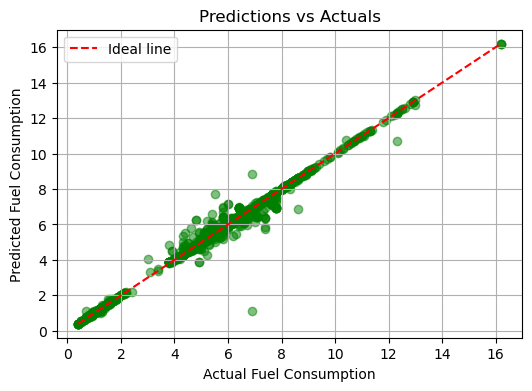

In [234]:
import matplotlib.pyplot as plt

# Plotting predictions vs actual values
plt.figure(figsize=(6, 4))
plt.scatter(y_eval, y_pred, color='green', alpha=0.5)
plt.plot([min(y_eval), max(y_eval)], [min(y_eval), max(y_eval)], color='red', linestyle='--', label='Ideal line')
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Fuel Consumption')
plt.ylabel('Predicted Fuel Consumption')
plt.legend()
plt.grid(True)
plt.show()


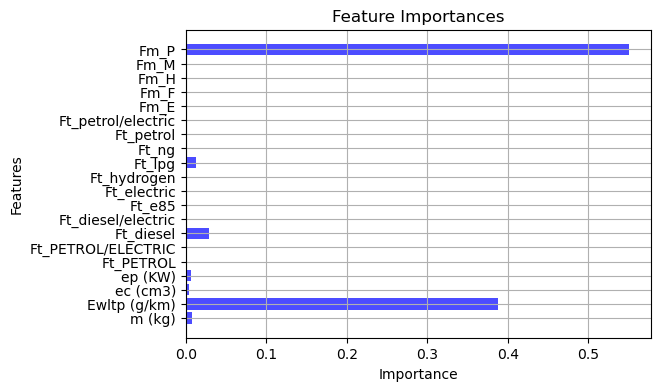

In [84]:
# Plot feature importances
importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
plt.barh(features, importances, color='blue', alpha=0.7)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


** Now running the saved scripts on jupyter notebook - train_model.py // predict_fraud.py // app.py ***

In [226]:
# Importing the training script
!python train_model.py

Dataset successfully loaded...


Initiating RandomForestRegressor....

Model training complete and saved.


In [228]:
# Importing the Predict script
!python predict_model.py

Data loading successful... initiating prediction

Predictions:
[5.8 6.6 6.  5.5 4.3 2.  1.1 4.8 5.4 5.4]


In [230]:
import subprocess

# Now running the Flask app using subprocess
subprocess.Popen(["python", "app.py"])

<Popen: returncode: None args: ['python', 'app.py']>

In [232]:
import requests

data = {
    "Ft": ["electric"],
    "Fm": ["manual"],
    "m (kg)": [1500],
    "Mt": [3],
    "Ewltp (g/km)": [120],
    "ec (cm3)": [2000],
    "ep (KW)": [100],
    "Electric range (km)": [200]
}

response = requests.post("http://127.0.0.1:5000/predict", json=data)

print(response.json())  # This will print the prediction result


[6.014975380226921]


127.0.0.1 - - [30/Dec/2024 11:30:52] "POST /predict HTTP/1.1" 200 -
